### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that", "by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "have", "this", "which", "been", "not", "has", "its", "also", "these", "this", "can", "a", 'it', 'their', "e.g.", "those", "had", "but", "while", "will", "when", "only", "author", "title", "there", "our", "did", "as", "if", "they", "such", "than", "no", "-", "could"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete"
session_folder_name = abstracts_log_name.split('/')[-1]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[-1]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
num_topics = 12

nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = num_topics, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

[INFO]13:4:57 Initiating the NLP Engine
[INFO]13:4:57 ~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt is being ported to dataframe
[INFO]13:4:57 ~/projects/Bias/BackUp_Journal_LOGS/Barbara_Data/Barbara_12_Data/Barbara_ANALYTICAL_Complete/BarbaraData_ANALYTICAL_Complete.txt has been ported to dataframe
[INFO]13:4:57 Trimming data and preparing list of words
[['A seasonal rodent-borne disease surveillance program was established at Dagmar North Training Area located near the demilitarized zone, Republic of Korea, from 2001 through 2005. Selected habitats surveyed included earthen banks separating rice paddies, fighting positions along a 5 m rock-faced earthen berm, and extensive tall grasses with various degrees of herbaceous and scrub vegetation associated with dirt roads, rice paddies, ditches, ponds, or the Imjin River. Of the nine species of small mammals captured, the striped field mouse (Apodemus agrar

[INFO]13:4:57 Generating bigrams
[INFO]13:4:57 Generating word bigrams
[INFO]13:4:58 Generated word bigrams
[INFO]13:4:59 Beginning lemmatization
[INFO]13:5:1 Ending lemmatization
[INFO]13:5:3 Issued perplexity: -7.689495083633646
[INFO]13:5:3 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.032*"host" + 0.017*"disease" + 0.016*"human" + 0.016*"bat" + 0.015*"vector" + 0.015*"pathogen" + 0.012*"reservoir" + 0.011*"transmission" + 0.010*"specie" + 0.010*"suggest"'),
 (1,
  '0.020*"americanum" + 0.017*"troop" + 0.014*"mongoose" + 0.014*"garbage" + 0.014*"study" + 0.013*"site" + 0.012*"forage" + 0.011*"behavior" + 0.011*"individual" + 0.008*"sleep"'),
 (2,
  '0.029*"host" + 0.015*"chigger" + 0.012*"specie" + 0.011*"habitat" + 0.010*"disease" + 0.010*"population" + 0.009*"prevalence" + 0.009*"parasite" + 0.008*"vector" + 0.007*"individual"'),
 (3,
  '0.015*"tick" + 0.015*"mammal" + 0.014*"study" + 0.011*"small" + 0.010*"prevalence" + 0.009*"area" + 0.009*"host" + 0.009*"specie" + 0.009*"sample" + 0.008*"isolate"'),
 (4,
  '0.011*"peridomestic_setting" + 0.010*"community" + 0.010*"andv" + 0.008*"metacommunity" + 0.006*"clementsian" + 0.006*"metacommunitie" + 0.006*"probability" + 0.006*"longicaudatus" + 0.005*"coccidian" + 0.005*"sylvan"'),
 (5,
  '0.043*"tick" + 0.029

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [17]:
pprint(ldamallet.show_topics(formatted=False))

[(11,
  [('virus', 0.06386066763425254),
   ('wild', 0.040638606676342524),
   ('mammal', 0.038461538461538464),
   ('antibody', 0.02830188679245283),
   ('test', 0.02467343976777939),
   ('dog', 0.023222060957910014),
   ('human', 0.023222060957910014),
   ('infect', 0.023222060957910014),
   ('ecology', 0.020319303338171262),
   ('tularensis', 0.016690856313497822)]),
 (4,
  [('detect', 0.029082774049217),
   ('isolate', 0.029082774049217),
   ('animal', 0.020134228187919462),
   ('presence', 0.017897091722595078),
   ('agent', 0.017897091722595078),
   ('finding', 0.01715137956748695),
   ('dna', 0.01640566741237882),
   ('parasite', 0.01640566741237882),
   ('pcr', 0.015659955257270694),
   ('observe', 0.014168530947054437)]),
 (9,
  [('tick', 0.08084824387011266),
   ('host', 0.05036447978793903),
   ('mammal', 0.04638833664678595),
   ('small', 0.043074884029158385),
   ('mouse', 0.03578528827037773),
   ('specie', 0.023194168323392977),
   ('vector', 0.023194168323392977),
   ('

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3657428997627674


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

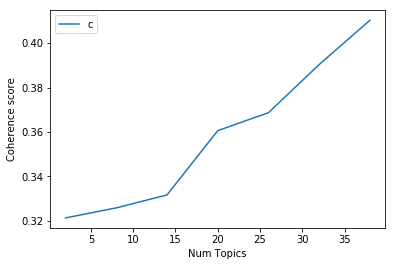

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.081*"specie" + 0.080*"human" + 0.033*"host" + 0.026*"mammal" + '
  '0.026*"vector" + 0.025*"feed" + 0.020*"mosquito" + 0.019*"significant" + '
  '0.019*"study" + 0.018*"similar" + 0.017*"identify" + 0.016*"time" + '
  '0.016*"compare" + 0.014*"large" + 0.014*"blood" + 0.014*"transmit" + '
  '0.013*"role" + 0.012*"exotic" + 0.012*"bird" + 0.011*"pattern" + '
  '0.010*"potential" + 0.010*"area" + 0.009*"trap" + 0.009*"difference" + '
  '0.008*"feeding" + 0.008*"spatial" + 0.007*"germany" + 0.007*"differ" + '
  '0.007*"total" + 0.006*"fauna" + 0.006*"species" + 0.006*"success" + '
  '0.006*"source" + 0.006*"specimen" + 0.006*"engorge" + 0.006*"spread" + '
  '0.005*"main" + 0.005*"information" + 0.005*"make" + 0.005*"competent"'),
 (1,
  '0.048*"population" + 0.032*"individual" + 0.023*"effect" + 0.022*"dynamic" '
  '+ 0.019*"provide" + 0.018*"model" + 0.017*"affect" + 0.016*"epidemic" + '
  '0.015*"decline" + 0.015*"impact" + 0.015*"influence" + 0.015*"rate" + '
  '0.014*"level"

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.3855,"rodent, number, spp, infection, distribution, ...",[A seasonal rodent-borne disease surveillance ...
1,1,8.0,0.4360,"disease, increase, transmission, small, potent...",[Alterations in transmission of vector-borne z...
2,2,6.0,0.2290,"rodent, number, spp, infection, distribution, ...",[Although the importance of rodents as reservo...
3,3,0.0,0.3671,"specie, human, host, mammal, vector, feed, mos...",[Amblyomma macula turn Koch is the primary vec...
4,4,9.0,0.1537,"tick, host, mammal, small, mouse, specie, vect...",[An inventory and monitoring program for speci...
5,5,11.0,0.4741,"virus, wild, mammal, antibody, test, dog, huma...",[Avian influenza (AI) viruses primarily circul...
6,6,0.0,0.4266,"specie, human, host, mammal, vector, feed, mos...",[Background: Aedes albopictus is an invasive s...
7,7,0.0,0.5992,"specie, human, host, mammal, vector, feed, mos...",[Background: Mosquito-borne pathogens are of g...
8,8,8.0,0.3287,"disease, increase, transmission, small, potent...",[Background: The two most reported mosquito-bo...
9,9,10.0,0.2653,"host, pathogen, specie, bat, parasite, suggest...",[Bats are known reservoirs for numerous emergi...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet['Number_Papers'] = [topic_counts[count] for count in range(num_topics)]
sent_topics_sorteddf_mallet['Percentage_Papers'] = [topic_contribution[count] for count in range(0, num_topics)]
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

In [31]:
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,Number_Papers,Percentage_Papers
0,0.0,0.5992,"specie, human, host, mammal, vector, feed, mos...",[Background: Mosquito-borne pathogens are of g...,4,0.0292
1,1.0,0.5501,"population, individual, effect, dynamic, provi...","[Immunosenescence, the deterioration of immune...",10,0.0730
2,2.0,0.5327,"analysis, community, find, health, environment...",[Gut microbiota play an important role in main...,10,0.0730
3,3.0,0.5489,"sample, plague, study, prevalence, colony, are...",[Sylvatic plague (Yersinia pestis) was introdu...,11,0.0803
4,4.0,0.4746,"detect, isolate, animal, presence, agent, find...","[Background: Trypanosoma cruzi, the agent of C...",8,0.0584
5,5.0,0.4427,"rat, include, study, risk, forest, population,...",[How do animals use their habitat? Where do th...,9,0.0657
6,6.0,0.3855,"rodent, number, spp, infection, distribution, ...",[A seasonal rodent-borne disease surveillance ...,17,0.1241
7,7.0,0.5027,"high, habitat, infection, low, site, examine, ...",[The characteristic striped appearance of zebr...,10,0.0730
8,8.0,0.4953,"disease, increase, transmission, small, potent...",[Lyme disease is the most prevalent vector-bor...,9,0.0657
9,9.0,0.4599,"tick, host, mammal, small, mouse, specie, vect...",[The aim of this study was to improve understa...,22,0.1606


Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [32]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)

In [33]:
vis = pyLDAvis.gensim.prepare(model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:223: RuntimeWarning: divide by zero encountered in log
  kernel = (topic_given_term * np.log((topic_given_term.T / topic_proportion).T))
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:240: RuntimeWarning: divide by zero encountered in log
  log_lift = np.log(topic_term_dists / term_proportion)
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:241: RuntimeWarning: divide by zero encountered in log
  log_ttd = np.log(topic_term_dists)
/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [34]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [35]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [36]:
vis

PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
1      9.086956        1       1 -0.176509 -0.206147
8      8.795496        1       2  0.080831 -0.104970
0      8.692901        1       3  0.213347  0.121383
10     8.568663        1       4  0.211658 -0.086477
9      8.564491        1       5  0.230424  0.171028
5      8.487709        1       6 -0.020519 -0.253086
7      8.434779        1       7 -0.131503  0.113281
11     8.151025        1       8  0.064093  0.022089
4      7.959598        1       9 -0.041988 -0.124102
2      7.836836        1      10 -0.014977 -0.000640
6      7.803594        1      11 -0.214290  0.153827
3      7.617951        1      12 -0.200568  0.193815, topic_info=     Category        Freq             Term       Total  loglift  logprob
822   Default  220.000000          disease  220.000000  30.0000  30.0000
3184  Default  262.000000             host  262.000000  29.0000  29.0000
3539  Default  125.000000             tick  125.000000  28.0000  28.0000
3338  Default  159.000000            human  159.000000  27.0000  27.0000
2507  Default  243.000000           specie  243.000000  26.0000  26.0000
3506  Default  106.000000         pathogen  106.000000  25.0000  25.0000
1924  Default   94.000000            virus   94.000000  24.0000  24.0000
1591  Default  202.000000           mammal  202.000000  23.0000  23.0000
3198  Default  108.000000             high  108.000000  22.0000  22.0000
1259  Default  114.000000       population  114.000000  21.0000  21.0000
601   Default  111.000000            small  111.000000  20.0000  20.0000
1393  Default  100.000000           rodent  100.000000  19.0000  19.0000
2076  Default   74.000000           sample   74.000000  18.0000  18.0000
2248  Default   73.000000         increase   73.000000  17.0000  17.0000
348   Default   59.000000           plague   59.000000  16.0000  16.0000
352   Default  145.000000            study  145.000000  15.0000  15.0000
990   Default   75.000000             wild   75.000000  14.0000  14.0000
2825  Default   60.000000          habitat   60.000000  13.0000  13.0000
2859  Default   81.000000     transmission   81.000000  12.0000  12.0000
3206  Default   55.000000            mouse   55.000000  11.0000  11.0000
952   Default   77.000000           vector   77.000000  10.0000  10.0000
1410  Default   52.000000           number   52.000000   9.0000   9.0000
1896  Default   53.000000              rat   53.000000   8.0000   8.0000
689   Default   52.000000       individual   52.000000   7.0000   7.0000
194   Default  108.000000        infection  108.000000   6.0000   6.0000
398   Default   56.000000          include   56.000000   5.0000   5.0000
1337  Default   49.000000              bat   49.000000   4.0000   4.0000
570   Default   75.000000       prevalence   75.000000   3.0000   3.0000
714   Default   63.000000             risk   63.000000   2.0000   2.0000
972   Default   72.000000          suggest   72.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
2504  Topic12   10.768768        epizootic   10.768768   2.5747  -4.8512
2839  Topic12   10.768768        australia   10.768768   2.5747  -4.8512
2184  Topic12    9.691891         sylvatic    9.691891   2.5747  -4.9566
118   Topic12    9.691891          coastal    9.691891   2.5747  -4.9566
1595  Topic12    9.691891          ulceran    9.691891   2.5747  -4.9566
192   Topic12    8.615015            point    8.615015   2.5747  -5.0744
3406  Topic12    8.615015     northeastern    8.615015   2.5747  -5.0744
2212  Topic12    8.615015        elucidate    8.615015   2.5747  -5.0744
833   Topic12    8.615015           pestis    8.615015   2.5747  -5.0744
2752  Topic12    7.538138  yersinia_pestis    7.538138   2.5747  -5.2079
3178  Topic12    7.538138           threat    7.538138   2.5747  -5.2079
2377  Topic12    7.538138      prairie_dog    7.538138   2.5747  -5.2079
251